# Ways To Build And Manage A Computation Graph in Python

This Python notebook is in response to a question I posted on Stack Overflow:

> [Best way to 'intelligently' reset memoized property values in Python when dependencies change](https://stackoverflow.com/questions/57439169/best-way-to-intelligently-reset-memoized-property-values-in-python-when-depend)


**Contents**

1. Static Calculation Object in Python - only does the calculation once
2. Dynamic Calculation Object in Python - recalculates every time you request a value (lazy but inefficient)
3. Computation Graph with Memoisation using Python Built-ins - only recalculates if it needs to (lazy and efficient)
4. Computation Graph using Pythonflow Package - recalculates every time you request a value (lazy but inefficient)
5. Computation Graph using Pythonflow and Class Properties - same as above
6. Computation Graph using Dask - recalculates every time you request a value (lazy but inefficient)


## 1. Static Calculation Object in Python

In this first example, the calculation is done when the object is initialized and is not re-calculated again.  To avoid any ambiguity, none of the object's attributes can be changed after initialization.  Use this method when you need to do a calculation once and want to store the results but don't need to re-do it later.

In [1]:
from math import pi


class Cylinder:

    def __init__(self, radius, length, density):
        self._length = length
        self._radius = radius
        self._density = density
        self._volume = self.calculate_volume(self.length, self.radius)
        self._mass = self.calculate_mass(self.volume, self.density)

    @staticmethod
    def calculate_volume(length, radius):
        """Calculates cylinder's volume."""
        print("Volume calculated")
        return length*pi*radius**2

    @staticmethod
    def calculate_mass(volume, density):
        """Calculates cylinder's mass."""
        print("Mass calculated")
        return volume*density

    @property
    def length(self):
        return self._length

    @property
    def radius(self):
        return self._radius

    @property
    def density(self):
        return self._density

    @property
    def volume(self):
        return self._volume

    @property
    def mass(self):
        return self._mass


In [2]:
c = Cylinder(0.25, 1.0, 450)

Volume calculated
Mass calculated


In [3]:
c.radius

0.25

In [4]:
c.length

1.0

In [5]:
c.density

450

In [6]:
c.volume

0.19634954084936207

In [7]:
c.mass

88.35729338221293

In [8]:
try:
    c.length = 2  # Try to change it!
except AttributeError as err:
    print(err)

can't set attribute


In [9]:
c.mass

88.35729338221293

In [10]:
c.volume

0.19634954084936207

In [11]:
try:
    c.volume = 0  # Try to change it!
except AttributeError as err:
    print(err)

can't set attribute


## 2. Dynamic Calculation Object in Python

In this example, the object is instantiated with initial values but the calculations are not executed until the resulting values are requested.  Every time any values are requested, all calculations related to that value are re-computed (regardless of whether they need to be).  This is a safe but potentially inefficient solution.

In [12]:
from math import pi


class Cylinder:

    def __init__(self, radius, length, density):
        self._length = length
        self._radius = radius
        self._density = density
        self._volume = None
        self._mass = None

    @staticmethod
    def calculate_volume(length, radius):
        """Calculates cylinder's volume."""
        print("Volume calculated")
        return length*pi*radius**2

    @staticmethod
    def calculate_mass(volume, density):
        """Calculates cylinder's mass."""
        print("Mass calculated")
        return volume*density

    @property
    def length(self):
        return self._length

    @length.setter
    def length(self, value):
        self._length = value

    @property
    def radius(self):
        return self._radius

    @radius.setter
    def radius(self, value):
        self._radius = value

    @property
    def density(self):
        return self._density

    @density.setter
    def density(self, value):
        self._density = value

    @property
    def volume(self):
        self._volume = self.calculate_volume(self.length, self.radius)
        return self._volume

    @property
    def mass(self):
        self._mass = self.calculate_mass(self.volume, self.density)
        return self._mass


In [13]:
c = Cylinder(0.25, 1.0, 450)

In [14]:
c.radius

0.25

In [15]:
c.length

1.0

In [16]:
c.density

450

In [17]:
c.volume

Volume calculated


0.19634954084936207

In [18]:
c.mass

Volume calculated
Mass calculated


88.35729338221293

In [19]:
try:
    c.length = 2  # Try to change it!
except AttributeError as err:
    print(err)

In [20]:
c.mass

Volume calculated
Mass calculated


176.71458676442586

In [21]:
c.volume

Volume calculated


0.39269908169872414

In [22]:
try:
    c.volume = 0  # Try to change it!
except AttributeError as err:
    print(err)

can't set attribute


## 3. Computation Graph with Memoisation using Python Built-ins

Here, the class has an explicit computation graph which it uses to determine whether calculations need to be re-done (if dependent parameters have changed) or not.  This is both safe and efficient (as long as you make sure the computation graph is properly specified and up to date).

In [23]:
from itertools import chain


class Cylinder:

    _dependencies = {
        "length": ["volume"],
        "radius": ["volume"],
        "volume": ["mass"],
        "density": ["mass"]
    }
    _dependent_vars = set(chain(*list(_dependencies.values())))

    def __init__(self, radius, length, density):
        self._length = length
        self._radius = radius
        self._density = density
        self._volume = None
        self._mass = None

    def _reset_dependent_vars(self, name):
        for var in self._dependencies[name]:
            super().__setattr__(f"_{var}", None)
            if var in self._dependencies:
                self._reset_dependent_vars(var)

    def __setattr__(self, name, value):
        if name in self._dependent_vars:
            raise AttributeError("can't set attribute")
        if name in self._dependencies:
            self._reset_dependent_vars(name)
            name = f"_{name}"
        super().__setattr__(name, value)

    @property
    def volume(self):
        """Calculates cylinder's volume."""
        if self._volume is None:
            self._volume = self.length*pi*self.radius**2
            print("Volume calculated")
        return self._volume

    @property
    def mass(self):
        """Calculates cylinder's mass."""
        if self._mass is None:
            self._mass = self.volume*self.density
            print("Mass calculated")
        return self._mass

    @property
    def length(self):
        return self._length

    @property
    def radius(self):
        return self._radius

    @property
    def density(self):
        return self._density

In [24]:
c = Cylinder(0.25, 1.0, 450)

In [25]:
c.radius

0.25

In [26]:
c.length

1.0

In [27]:
c.density

450

In [28]:
c.volume

Volume calculated


0.19634954084936207

In [29]:
c.mass

Mass calculated


88.35729338221293

In [30]:
c.length = 2  # This should change things!

In [31]:
c.mass

Volume calculated
Mass calculated


176.71458676442586

In [32]:
c.volume

0.39269908169872414

In [33]:
try:
    c.volume = 0
except AttributeError as err:
    print(err)

can't set attribute


## 4. Computation Graph using Pythonflow Package

This package automatically constructs the computation graph for you based on the calculations you define.  However, it redoes all the calculations each time you request a value, even if the dependent values haven't changed.  This is a safe but potentially inefficient solution.

In [34]:
from math import pi
import pythonflow as pf


with pf.Graph() as graph:
    pi = pf.constant(pi)
    length = pf.constant(1.0)
    radius = pf.constant(0.25)
    density = pf.constant(450)
    volume = length*pi*radius**2
    mass = volume*density

In [35]:
graph(volume)

0.19634954084936207

In [36]:
graph(mass)

88.35729338221293

In [37]:
graph(volume, {length: graph(length)*2})

0.39269908169872414

In [38]:
graph(mass, {length: graph(length)*2})

176.71458676442586

In [39]:
graph(mass, {length: graph(length)*2})

176.71458676442586

In [40]:
# Problem is, I think it is still recalculating all dependencies each time...


## 5. Computation Graph using Pythonflow and Class Properties

Same as above but built into the same class structure as the other examples here.

In [41]:
from math import pi


class Cylinder:

    def __init__(self, radius, length, density):
        self._length = length
        self._radius = radius
        self._density = density
        self._volume = None
        self._mass = None
        with pf.Graph() as graph:
            self._pf_radius = pf.placeholder(name='_radius')
            self._pf_length = pf.placeholder(name='_length')
            self._pf_density = pf.placeholder(name='_density')

            # Build computation graph
            self._pf_volume = self._pf_length*pi*self._pf_radius**2
            self._pf_mass = self._pf_volume*self._pf_density
            self.graph = graph

    def _pf_values(self):
        return {
            self._pf_radius: self._radius,
            self._pf_length: self._length,
            self._pf_density: self._density
        }
    
    @property
    def volume(self):
        """Calculates cylinder's volume."""
        print("Volume calculated")
        return self.graph(self._pf_volume, self._pf_values())

    @property
    def mass(self):
        """Calculates cylinder's mass."""
        print("Mass calculated")
        return self.graph(self._pf_mass, self._pf_values())

    @property
    def length(self):
        return self._length

    @length.setter
    def length(self, value):
        self._length = value

    @property
    def radius(self):
        return self._radius

    @radius.setter
    def radius(self, value):
        self._radius = value

    @property
    def density(self):
        return self._density

    @density.setter
    def density(self, value):
        self._density = value


In [42]:
c = Cylinder(0.25, 1.0, 450)

In [43]:
c.radius

0.25

In [44]:
c.length

1.0

In [45]:
c.density

450

In [46]:
c.volume

Volume calculated


0.19634954084936207

In [47]:
c.mass

Mass calculated


88.35729338221293

In [48]:
c.length = 2  # This should change things!
c.length

2

In [49]:
c.mass

Mass calculated


176.71458676442586

In [50]:
c.volume

Volume calculated


0.39269908169872414

In [51]:
try:
    c.volume = 0
except AttributeError as err:
    print(err)

can't set attribute


In [52]:
#TODO: Can it cache values and do lazy evaluation?  I don't think so.

## 6. Computation Graph using Dask

In [53]:
from math import pi
from dask import delayed, compute


class Cylinder:

    def __init__(self, radius, length, density):
        self._length = length
        self._radius = radius
        self._density = density
        
        # Build computation graphs
        self._length_graph = self.length
        self._radius_graph = self.radius
        self._density_graph = self.density
        self._volume_graph = self.calculate_volume(self.get_length(), self.get_radius())
        self._mass_graph = self.calculate_mass(self._volume_graph, self.get_density())

    @delayed
    def get_length(self):
        return self._length

    @delayed
    def get_radius(self):
        return self._radius

    @delayed
    def get_density(self):
        return self._density

    @delayed
    def calculate_volume(self, length, radius):
        """Calculates cylinder's volume."""
        print("Volume calculated")
        return length*pi*radius**2

    @delayed
    def calculate_mass(self, volume, density):
        """Calculates cylinder's mass."""
        print("Mass calculated")
        return volume*density

    @property
    def length(self):
        return self._length

    @length.setter
    def length(self, value):
        self._length = value

    @property
    def radius(self):
        return self._radius

    @radius.setter
    def radius(self, value):
        self._radius = value

    @property
    def density(self):
        return self._density

    @density.setter
    def density(self, value):
        self._density = value

    @property
    def volume(self):
        return self._volume_graph.compute()

    @property
    def mass(self):
        return self._mass_graph.compute()


In [54]:
c = Cylinder(0.25, 1.0, 450)

In [55]:
c.radius

0.25

In [56]:
c.length

1.0

In [57]:
c.density

450

In [58]:
c.volume

Volume calculated


0.19634954084936207

In [59]:
c.mass

Volume calculated
Mass calculated


88.35729338221293

In [60]:
c.length = 2  # This should change things!

In [61]:
c.mass

Volume calculated
Mass calculated


176.71458676442586

In [62]:
c.volume

Volume calculated


0.39269908169872414

In [63]:
try:
    c.volume = 0
except AttributeError as err:
    print(err)

can't set attribute


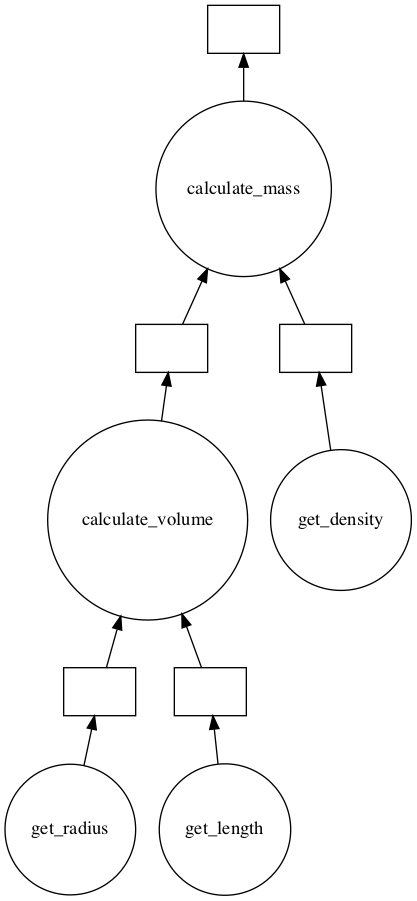

In [64]:
c._mass_graph.visualize()

In [65]:
#TODO: Is there a way to do caching and minimal evaluation in Dask?